# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
%matplotlib inline

In [2]:
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image-predictions2.tsv', mode='wb') as file:
    file.write(response.content)

In [4]:
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive_enhanced.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


In [89]:
tweet_json = pd.read_json('tweet-json.txt', lines=True)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### `twitter_archive_enhanced.csv`

In [6]:
twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [7]:
# Select only original ratings (no retweets)
twitter_archive_enhanced = twitter_archive_enhanced[twitter_archive_enhanced['retweeted_status_user_id'].isnull()]

In [8]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [9]:
twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.175000e+03,7.800000e+01,7.800000e+01,0.0,0.0,2175.000000,2175.000000
mean,7.371205e+17,7.455079e+17,2.014171e+16,NaN,NaN,13.215172,10.492874
std,6.748668e+16,7.582492e+16,1.252797e+17,NaN,NaN,47.725696,7.019084
min,6.660209e+17,6.658147e+17,1.185634e+07,NaN,NaN,0.000000,0.000000
25%,6.768432e+17,6.757419e+17,3.086374e+08,NaN,NaN,10.000000,10.000000
50%,7.098528e+17,7.038708e+17,4.196984e+09,NaN,NaN,11.000000,10.000000
75%,7.894226e+17,8.257804e+17,4.196984e+09,NaN,NaN,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,NaN,NaN,1776.000000,170.000000


### `image-predictions.tsv`

In [10]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [11]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### `tweet_json.txt`

In [12]:
tweet_json

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2015-11-16 00:24:50+00:00,666049248165822465,666049248165822464,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,111,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2350,2015-11-16 00:04:52+00:00,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,311,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2351,2015-11-15 23:21:54+00:00,666033412701032449,666033412701032448,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,128,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2352,2015-11-15 23:05:30+00:00,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,132,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [13]:
tweet_json = tweet_json[['created_at', 'id', 'retweet_count', 'favorite_count']]
tweet_json

,created_at,id,retweet_count,favorite_count
0,2017-08-01 16:23:56+00:00,892420643555336193,8853,39467
1,2017-08-01 00:17:27+00:00,892177421306343426,6514,33819
2,2017-07-31 00:18:03+00:00,891815181378084864,4328,25461
3,2017-07-30 15:58:51+00:00,891689557279858688,8964,42908
4,2017-07-29 16:00:24+00:00,891327558926688256,9774,41048
...,...,...,...,...
2349,2015-11-16 00:24:50+00:00,666049248165822465,41,111
2350,2015-11-16 00:04:52+00:00,666044226329800704,147,311
2351,2015-11-15 23:21:54+00:00,666033412701032449,47,128
2352,2015-11-15 23:05:30+00:00,666029285002620928,48,132


In [14]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   created_at      2354 non-null   datetime64[ns, UTC]
 1   id              2354 non-null   int64              
 2   retweet_count   2354 non-null   int64              
 3   favorite_count  2354 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(3)
memory usage: 73.7 KB


### Quality issues
#### `twitter_archive_enhanced` table
1. There are empty columns or columns with very little data
2. There are ratings without images
3. Dog stages not present are represented with a string, *None*, instead of NaN
4. There are missing Dog names represented with the string, *None*
5. There are Dog names with just the character **a**
6. Erroneous datatypes (timestamp, expanded_urls)
7. Some rating numerators and denominators are 0
8. Some expanded_urls have the same url repeated more than once 
9. Incomplete data in image_predictions (2075)

### Tidiness issues
- The dog stage in `twitter-archive-enhanced.csv` should be combined into one column, `dog_stage`
- Each tweet's retweet and like count should be in the same table as the rest of the tweet's data
- The `p1`, `p1_conf`, and `p1_dog` columns of the `image_predictions` table should be part of the `twitter_archive_enhanced` table

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [15]:
# Make copies of original pieces of data
twitter_archive_enhanced_copy = twitter_archive_enhanced.copy()
image_predictions_copy = image_predictions.copy()
tweet_json_copy = tweet_json.copy()

### Quality Issues

### Quality Issue #1: There are ratings that do not have images

#### Define: Drop these columns: the retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, in_reply_to_status_id, in_reply_to_user_id

#### Code

In [16]:
# Drop empty columns
twitter_archive_enhanced_copy.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1, inplace=True)

### Quality Issue #2: There are ratings that do not have images

#### Define: Select only ratings that have images with pandas filter

#### Code

In [17]:
# Select original ratings that have images
twitter_archive_enhanced = twitter_archive_enhanced[twitter_archive_enhanced['expanded_urls'].notnull()]

### Quality Issue #3 & 4:

#### Define: Replace None with NaN in the following columns: *name, doggo, floofer, pupper, puppo*

#### Code

In [18]:
twitter_archive_enhanced_copy = twitter_archive_enhanced_copy.replace('None', np.nan)

#### Test

In [19]:
twitter_archive_enhanced_copy.tail(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2354,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,NaN,NaN,NaN,NaN
2355,666020888022790149,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,NaN,NaN,NaN,NaN,NaN


### Tidiness Issues

### Tidiness Issue #1: The dog stage in twitter-archive-enhanced.csv should be combined into one column, dog_stage

#### Define: Combine the dog stage columns into one by 

#### Code

In [ ]:
twitter_archive_enhanced_copy = pd.melt(twitter_archive_enhanced_copy, id_vars=['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'],
                           var_name='treatment', value_name='dose')

In [20]:
dog_stage = []

for index, row in twitter_archive_enhanced_copy.iterrows():
    if pd.isnull(twitter_archive_enhanced_copy.loc[index, 'doggo']) == False:
        dog_stage.append('doggo')
    elif pd.isnull(twitter_archive_enhanced_copy.loc[index, 'floofer']) == False:
        dog_stage.append('floofer')
    elif pd.isnull(twitter_archive_enhanced_copy.loc[index, 'pupper']) == False:
        dog_stage.append('pupper')
    elif pd.isnull(twitter_archive_enhanced_copy.loc[index, 'puppo']) == False:
        dog_stage.append('puppo')
    else:
        dog_stage.append(np.nan)

In [21]:
twitter_archive_enhanced_copy['dog_stage'] = dog_stage

In [22]:
# Drop dog_stage individual columns that have now been combined to one
twitter_archive_enhanced_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1, inplace=True)

#### Test

In [23]:
twitter_archive_enhanced_copy.dtypes

tweet_id               int64
timestamp             object
source                object
text                  object
expanded_urls         object
rating_numerator       int64
rating_denominator     int64
name                  object
dog_stage             object
dtype: object

### Tidiness Issue #2: Each tweet's retweet and favorite count should be in the same table as the rest of the tweet's data

#### Define: Add each tweet's retweet and favorite count to the twitter archive dataframe based on the tweet id

#### Code

In [24]:
# Create the retweet_count and like_count columns in the twitter_archive_enhanced_copy dataframe
twitter_archive_enhanced_copy['retweet_count'] = np.nan
twitter_archive_enhanced_copy['favorite_count'] = np.nan

In [25]:
for index, row in twitter_archive_enhanced_copy.iterrows():
    #.loc[index, 'doggo']
    # Get the current tweet's Id
    tweetId = row['tweet_id']
    
    # Get the retweet_count and like_count from the tweet_json_copy dataframe
    retweetCount = tweet_json_copy.query('id == @tweetId')['retweet_count'].tolist()[0]   
    favoriteCount = tweet_json_copy.query('id == @tweetId')['favorite_count'].tolist()[0]
    
    # Add the favorite_count and retweet_count to the current row
    twitter_archive_enhanced_copy.loc[index, 'retweet_count'] = retweetCount
    twitter_archive_enhanced_copy.loc[index, 'favorite_count'] = favoriteCount

#### Test

In [26]:
twitter_archive_enhanced_copy.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,8853.0,39467.0
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,6514.0,33819.0


In [27]:
# Sample row from twitter_archive_enhanced_copy
sample_row = twitter_archive_enhanced_copy.sample(1)
sample_row_tweetId = sample_row["tweet_id"].tolist()[0]
sample_row_retweetCount = sample_row["retweet_count"].tolist()[0]
sample_row_favoriteCount = sample_row["favorite_count"].tolist()[0]

# Original row from tweet_json
test = tweet_json_copy.query('id == @sample_row_tweetId')

assert sample_row_retweetCount == test['retweet_count'].tolist()[0]
assert sample_row_favoriteCount == test['favorite_count'].tolist()[0]

### Tidiness Issue #3: The image_predictions table should combined with the twitter_archive_enhanced table

#### Define: Create columns for the image_predictions in the twitter_archive_enhanced dataframe then loop through all the rows and copy the values into the twitter_archive_enhanced columns.

#### Code

In [28]:
# Create the columns for the predictions
prediction_column_names = ['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']

for col_name in prediction_column_names:    
    twitter_archive_enhanced_copy[col_name] = ''
    
twitter_archive_enhanced_copy.p1_dog = twitter_archive_enhanced_copy.p1_dog.astype('bool')
twitter_archive_enhanced_copy.p2_dog = twitter_archive_enhanced_copy.p2_dog.astype('bool')
twitter_archive_enhanced_copy.p3_dog = twitter_archive_enhanced_copy.p3_dog.astype('bool')

In [29]:
twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2175 non-null   int64  
 1   timestamp           2175 non-null   object 
 2   source              2175 non-null   object 
 3   text                2175 non-null   object 
 4   expanded_urls       2117 non-null   object 
 5   rating_numerator    2175 non-null   int64  
 6   rating_denominator  2175 non-null   int64  
 7   name                1495 non-null   object 
 8   dog_stage           344 non-null    object 
 9   retweet_count       2175 non-null   float64
 10  favorite_count      2175 non-null   float64
 11  p1                  2175 non-null   object 
 12  p1_conf             2175 non-null   object 
 13  p1_dog              2175 non-null   bool   
 14  p2                  2175 non-null   object 
 15  p2_conf             2175 non-null   object 
 16  p2_dog

In [30]:
for index, row in image_predictions_copy.iterrows():
    # Get the current tweet's Id
    tweetId = row['tweet_id']
    correspondingTweet = twitter_archive_enhanced_copy.query('tweet_id == @tweetId')    

    # Assign the value of each column
    twitter_archive_enhanced_copy.loc[correspondingTweet.index, 'p1'] = row['p1']
    twitter_archive_enhanced_copy.loc[correspondingTweet.index, 'p1_conf'] = row['p1_conf']
    twitter_archive_enhanced_copy.loc[correspondingTweet.index, 'p1_dog'] = row['p1_dog']
    twitter_archive_enhanced_copy.loc[correspondingTweet.index, 'p2'] = row['p2']
    twitter_archive_enhanced_copy.loc[correspondingTweet.index, 'p2_conf'] = row['p2_conf']
    twitter_archive_enhanced_copy.loc[correspondingTweet.index, 'p1_dog'] = row['p1_dog']
    twitter_archive_enhanced_copy.loc[correspondingTweet.index, 'p3'] = row['p3']
    twitter_archive_enhanced_copy.loc[correspondingTweet.index, 'p3_conf'] = row['p3_conf']
    twitter_archive_enhanced_copy.loc[correspondingTweet.index, 'p3_dog'] = row['p3_dog']

#### Test

In [31]:
image_predictions_copy.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [32]:
twitter_archive_enhanced_copy.query('tweet_id == "666020888022790149"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2355,666020888022790149,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,NaN,NaN,532.0,2535.0,Welsh_springer_spaniel,0.465074,True,collie,0.156665,False,Shetland_sheepdog,0.0614285,True


### Quality Issue #5: There are Dog names with just the character a

#### Define: Replace Dog names with value 'a' with Nan

#### Code

In [33]:
twitter_archive_enhanced_copy['name'] = twitter_archive_enhanced_copy['name'].replace('a', np.nan)

#### Test

In [34]:
twitter_archive_enhanced_copy[twitter_archive_enhanced_copy['name'] == 'a']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Quality Issue #6: Erroneous datatypes (timestamp, expanded_urls)

#### Define: Use the astype function to convert timestamp to a datetime and expanded_urls to object

#### Code

In [35]:
twitter_archive_enhanced_copy['timestamp'] = pd.to_datetime(twitter_archive_enhanced_copy['timestamp']) 
twitter_archive_enhanced_copy['expanded_urls'] = twitter_archive_enhanced_copy['expanded_urls'].astype(str)

##### You do not need to gather the tweets beyond August 1st, 2017

In [36]:
# Filter the dataset by date
twitter_archive_enhanced_copy = twitter_archive_enhanced_copy.loc[(twitter_archive_enhanced_copy['timestamp'] \
        <= '2017-08-01') & (twitter_archive_enhanced_copy['timestamp'] >= '2015-11-15')]

#### Test

In [37]:
twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [38]:
twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 2 to 2355
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2173 non-null   int64              
 1   timestamp           2173 non-null   datetime64[ns, UTC]
 2   source              2173 non-null   object             
 3   text                2173 non-null   object             
 4   expanded_urls       2173 non-null   object             
 5   rating_numerator    2173 non-null   int64              
 6   rating_denominator  2173 non-null   int64              
 7   name                1438 non-null   object             
 8   dog_stage           344 non-null    object             
 9   retweet_count       2173 non-null   float64            
 10  favorite_count      2173 non-null   float64            
 11  p1                  2173 non-null   object             
 12  p1_conf             2173 non-null 

### Quality Issue #7: Some rating  denominators are 0

#### Define: Use the replace function to replace denominators that are 0

#### Code

In [39]:
twitter_archive_enhanced_copy['rating_denominator'] = twitter_archive_enhanced_copy['rating_denominator'].replace(0, 10)

#### Test

In [40]:
twitter_archive_enhanced_copy[twitter_archive_enhanced_copy['rating_denominator'] == 0]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Quality Issue #8: Some expanded_urls have the same url repeated more than once

#### Define: Use the string split function to select the first url only

#### Code

In [41]:
twitter_archive_enhanced_copy['expanded_urls'] = twitter_archive_enhanced_copy['expanded_urls'].str.split(',').str[0]

#### Test

In [42]:
twitter_archive_enhanced_copy.head(1)['expanded_urls']

2    https://twitter.com/dog_rates/status/891815181...
Name: expanded_urls, dtype: object

### Quality Issue #9: Incomplete data in image_predictions (2075)

#### Define: Drop rows with no image_predictions

#### Code

In [43]:
no_predictions_filter = twitter_archive_enhanced_copy['tweet_id'].isin(image_predictions_copy['tweet_id'])
# Filter tweets that do not have predictions
twitter_archive_enhanced_copy = twitter_archive_enhanced_copy[no_predictions_filter]

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [44]:
twitter_archive_enhanced_copy.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [4]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [46]:
twitter_archive_master

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,4328.0,25461.0,Chihuahua,0.716012,True,malamute,0.078253,False,kelpie,0.031379,True
1,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,8964.0,42908.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,False,spatula,0.040836,False
2,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,9774.0,41048.0,basset,0.555712,True,English_springer,0.225770,False,German_short-haired_pointer,0.175219,True
3,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,3261.0,20562.0,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,False,Indian_elephant,0.076902,False
4,890971913173991426,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,https://gofundme.com/ydvmve-surgery-for-jax,13,10,Jax,NaN,2158.0,12041.0,Appenzeller,0.341703,True,Border_collie,0.199287,False,ice_lolly,0.193548,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,41.0,111.0,miniature_pinscher,0.560311,True,Rottweiler,0.243682,False,Doberman,0.154629,True
1988,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,NaN,NaN,147.0,311.0,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,False,miniature_pinscher,0.222752,True
1989,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,NaN,NaN,47.0,128.0,German_shepherd,0.596461,True,malinois,0.138584,False,bloodhound,0.116197,True
1990,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,NaN,NaN,48.0,132.0,redbone,0.506826,True,miniature_pinscher,0.074192,False,Rhodesian_ridgeback,0.072010,True


In [5]:
# Select only predictions of dogs
twitter_archive_master = twitter_archive_master.query('p1_dog == True')

In [6]:
# Confirm that only dog predictions are in the dataframe
twitter_archive_master['p1_dog'].value_counts()

True    1476
Name: p1_dog, dtype: int64

In [7]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1476 entries, 0 to 1991
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1476 non-null   int64  
 1   timestamp           1476 non-null   object 
 2   source              1476 non-null   object 
 3   text                1476 non-null   object 
 4   expanded_urls       1476 non-null   object 
 5   rating_numerator    1476 non-null   int64  
 6   rating_denominator  1476 non-null   int64  
 7   name                1070 non-null   object 
 8   dog_stage           228 non-null    object 
 9   retweet_count       1476 non-null   float64
 10  favorite_count      1476 non-null   float64
 11  p1                  1476 non-null   object 
 12  p1_conf             1476 non-null   float64
 13  p1_dog              1476 non-null   bool   
 14  p2                  1476 non-null   object 
 15  p2_conf             1476 non-null   float64
 16  p2_dog

In [50]:
twitter_archive_master.describe()

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,p1_conf,p2_conf,p3_conf
count,1.476000e+03,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1.476000e+03
mean,7.405638e+17,11.564363,10.535230,2787.876694,9271.861789,0.614561,0.140957,6.162124e-02
std,6.851788e+16,7.889099,6.852003,4764.184389,12581.183930,0.260320,0.102490,5.260643e-02
min,6.660209e+17,1.000000,2.000000,16.000000,81.000000,0.044333,0.000023,2.160900e-07
25%,6.781969e+17,10.000000,10.000000,656.000000,2227.750000,0.392428,0.056939,1.524335e-02
50%,7.152104e+17,11.000000,10.000000,1442.500000,4503.000000,0.616099,0.126538,4.975535e-02
75%,7.945993e+17,12.000000,10.000000,3252.000000,11712.250000,0.853199,0.203656,9.499317e-02
max,8.918152e+17,165.000000,150.000000,79515.000000,132810.000000,0.999956,0.467678,2.734190e-01


In [93]:
twitter_archive_master['rating_numerator'].value_counts()

12     380
10     318
11     307
13     213
9      108
8       58
7       24
14      21
6       12
5       10
4        5
3        3
165      1
2        1
24       1
143      1
26       1
27       1
44       1
45       1
50       1
60       1
75       1
80       1
84       1
88       1
99       1
121      1
1        1
Name: rating_numerator, dtype: int64

## Exploratory Data Analysis

#### Group p1_conf into Low medium, moderately high, and high

In [96]:
# Group p1_conf () into Low medium, moderately high, and high
bin_edges = [0.044333, 0.392428, 0.616099, 0.853199, 0.999956]
bin_names = ['Low', 'Medium', 'Moderately High', 'High']
twitter_archive_master['p1_conf_CAT'] = pd.cut(twitter_archive_master['p1_conf'], bin_edges, labels=bin_names)

<ipython-input-96-0b393ec0b5f6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_archive_master['p1_conf_CAT'] = pd.cut(twitter_archive_master['p1_conf'], bin_edges, labels=bin_names)


In [143]:
twitter_archive_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,p1_conf_CAT
0,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,4328.0,...,Chihuahua,0.716012,True,malamute,0.078253,False,kelpie,0.031379,True,Moderately High
2,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,9774.0,...,basset,0.555712,True,English_springer,0.225770,False,German_short-haired_pointer,0.175219,True,Medium
3,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,3261.0,...,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,False,Indian_elephant,0.076902,False,Medium
4,890971913173991426,2017-07-28 16:27:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,https://gofundme.com/ydvmve-surgery-for-jax,13,10,Jax,NaN,2158.0,...,Appenzeller,0.341703,True,Border_collie,0.199287,False,ice_lolly,0.193548,False,Low
5,890729181411237888,2017-07-28 00:22:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,16716.0,...,Pomeranian,0.566142,True,Eskimo_dog,0.178406,False,Pembroke,0.076507,True,Medium


In [10]:
# Utility function to plot bar chart
def plotBarChart(x, y, title='', xlabel='', ylabel='', horizontal=False, figsize=(5,5), grid=False, color=None):
    plt.figure(figsize=figsize)
    if horizontal:
        plt.barh(x, y)
    else:
        plt.bar(x, y)
    
    if grid:
        plt.grid()
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

### Visualization

#### What is the distribution of rating_numerator?

<AxesSubplot:title={'center':'Percentages of Rating numerator'}, ylabel='rating_numerator'>

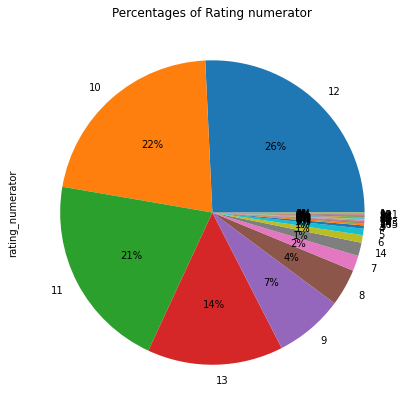

In [87]:
twitter_archive_master['rating_numerator'].value_counts().plot(kind='pie', autopct='%1.0f%%', title='Percentages of Rating numerator', figsize=(7,7))

#### What is the distribution of the top 20 predicted breeds (p1) of dogs?

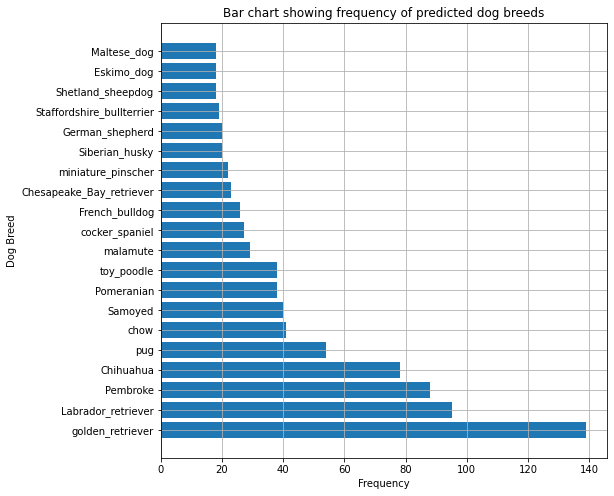

In [11]:
top20Breeds = twitter_archive_master.groupby('p1')['p1'].count().sort_values(axis=0, ascending=False)[:20]
plotBarChart(top20Breeds.index, top20Breeds.values, 
             'Bar chart showing frequency of predicted dog breeds', 'Frequency', 'Dog Breed', horizontal=True, figsize=(8,8), grid=True)

<AxesSubplot:title={'center':'Pie chart showing distribution of predicted dog breeds'}, ylabel='p1'>

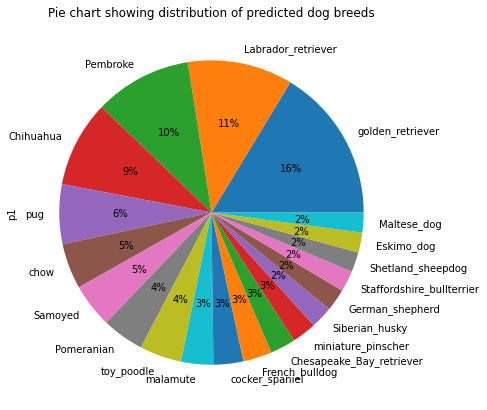

In [12]:
top20Breeds.plot(kind='pie', autopct='%1.0f%%', title='Pie chart showing distribution of predicted dog breeds', figsize=(7,7))

#### What is the distribution of the average retweet and favorite count for the top 20 predictions of breeds of dogs?

Text(0, 0.5, 'Predicted Dog breed (p1)')

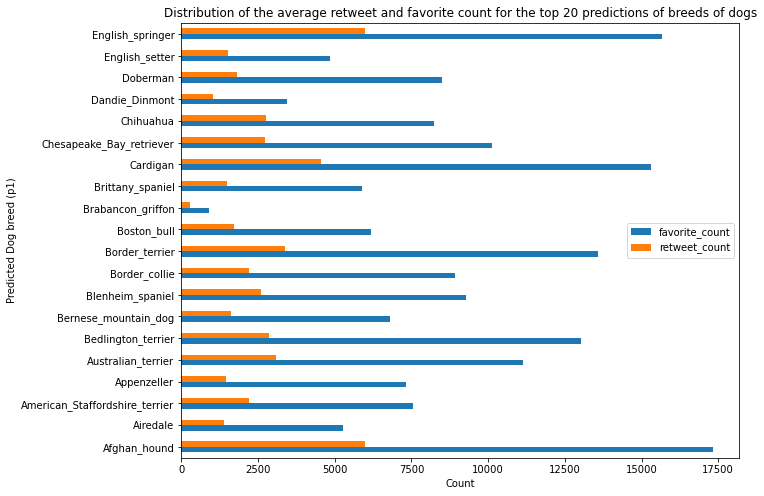

In [177]:
top20AvgRetweetFavoriteCount = twitter_archive_master.groupby('p1')[['favorite_count', 'retweet_count']].mean()[:20]
top20AvgRetweetFavoriteCountPlt = top20AvgRetweetFavoriteCount.plot(kind="barh", figsize=(10,8), title='Distribution of the average retweet and favorite count for the top 20 predictions of breeds of dogs')
top20AvgRetweetFavoriteCountPlt.set_xlabel('Count')
top20AvgRetweetFavoriteCountPlt.set_ylabel('Predicted Dog breed (p1)')

#### Which breed of dogs have the highest and lowest average predicition confidence (top 10 only)?

In [171]:
topAvgPredConfd = twitter_archive_master.groupby('p1')['p1_conf'].mean().sort_values(ascending=False)[:10]
# Multiply by scalar
topAvgPredConfd = topAvgPredConfd.mul(10)
#twitter_archive_master.groupby('p1')['p1_conf'].value_counts().sort_values(ascending=False)[:10].plot(kind='barh', figsize=(8,7))

In [14]:
bottomAvgPredConfd = twitter_archive_master.groupby('p1')['p1_conf'].mean().sort_values()[:10]
bottomAvgPredConfd = bottomAvgPredConfd.mul(10)
bottomAvgPredConfd

p1
Scottish_deerhound         1.823647
cairn                      2.621963
Scotch_terrier             2.679790
Norwich_terrier            2.954957
wire-haired_fox_terrier    3.055955
Australian_terrier         3.075835
silky_terrier              3.242510
Norfolk_terrier            3.314067
Bedlington_terrier         3.402426
Brabancon_griffon          3.699813
Name: p1_conf, dtype: float64

In [172]:
topAvgPredConfd 

p1
komondor                9.725310
clumber                 9.467180
Brittany_spaniel        8.745449
keeshond                8.444312
bull_mastiff            8.156184
Bernese_mountain_dog    8.018161
French_bulldog          7.706272
pug                     7.592231
Samoyed                 7.470880
Pomeranian              7.436059
Name: p1_conf, dtype: float64

Text(0, 0.5, 'Predicted Dog breed (p1)')

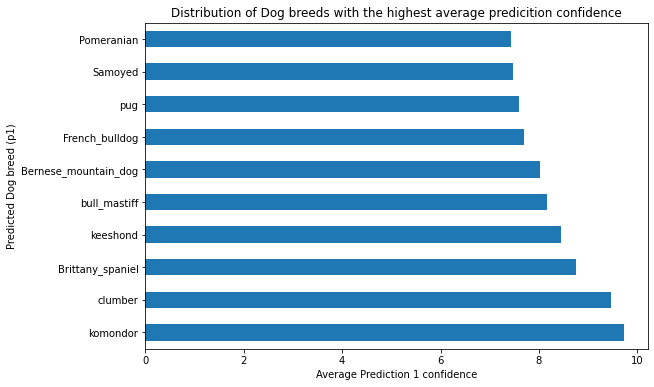

In [176]:
ax = topAvgPredConfd.plot(kind='barh', figsize=(9,6), title='Distribution of Dog breeds with the highest average predicition confidence')
ax.set_xlabel('Average Prediction 1 confidence')
ax.set_ylabel('Predicted Dog breed (p1)')

Text(0, 0.5, 'Predicted Dog breed (p1)')

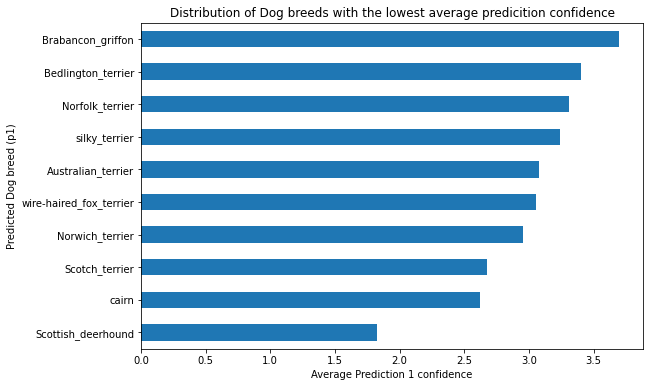

In [15]:
ax = bottomAvgPredConfd.plot(kind='barh', figsize=(9,6), title='Distribution of Dog breeds with the lowest average predicition confidence')
ax.set_xlabel('Average Prediction 1 confidence')
ax.set_ylabel('Predicted Dog breed (p1)')

### Insights:
- The most common rating_numerator in the tweets are 12 (26%), 10 (22%), 11 (21%), 13 (14%), 9 (7%), 8 (4%), 7 (2%)

- The top 5 most common predictions of dog breeds are Golden Retriever, Labrador Retriever, Pembroke, Chihuahua, and Pug.

- The breeds with the highest average favorite and retweet count are Afgan hound, English springer, Cardigan, Border terrier, and Bedlington terrier while Brabancon griffon is the dog breed with the lowest average favorite and retweet count. 

- The favorite counts are much higher than the retweet count.

- The dog breeds with the highest average prediction confidence are komondor, clumber, Brittany spaniel, keeshond, and Bull mastiff.
- The dog breeds with the lowest average prediction confidence are Brabancon griffon, Bedlington terrier, Norfolk terrier, silky terrier, and Australian terrier.